# Cluster analyses

This code splits the df into windows of a specified length. 
The result is a list with each cell containing time_length X channels. 
The raw data contains 200ms of a prewindow and 1000ms of the test window.

In [1]:
import pandas as pd
import numpy as np
import setup_jwlab
from jwlab.constants import cleaned_data_filepath
from jwlab.cluster_analysis import prep_cluster_analysis
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from scipy import stats
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn import preprocessing
from scipy.stats import kurtosis, skew
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
length_per_window = 20
num_sliding_windows = int(1200/ length_per_window)

In [3]:
participants = ["904", "905", "906", "908", "909", "912","913", "914", "916", "917", "919",\
                "920",  "923","921", "924", "927", "928", "929", "930", "932"]

In [3]:
participants = ["107", "109", "111", "112", "115", "116", "117", "119", "121", "122", "120", "124"]


In [3]:
participants = ["107", "109", "111", "112", "115", "116", "117", "119", "121", "122", "120", "124",\
               "904", "905", "906", "908", "909", "912","913", "914", "916", "917", "919",\
                "920", "921", "923", "924", "927", "928", "929", "930", "932"]


In [ ]:
X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="no_averaging", length_per_window=length_per_window)


In [ ]:
#get trial counts
for i in participants:
    ps =[i]
    X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, ps, downsample_num=1000, averaging="no_averaging", length_per_window=length_per_window)
    y[0]
    np.amax(y[0])
    unique, counts = np.unique(y[0], return_counts=True)
    
    print(i)
    print(dict(zip(unique, counts)))

## Train raw test avg

In [ ]:
X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="no_averaging", length_per_window=length_per_window)
Xt, yt, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="average_trials", length_per_window=length_per_window)
Xa, ya, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="average_trials_and_participants", length_per_window=length_per_window)

model = LinearSVC(C=1e-9, max_iter=5000)
#model = SVC(gamma=.001, kernel = 'rbf', C = 1e-6)

# from sklearn import preprocessing


results = {}



for j in range(num_sliding_windows):
    
        
        model.fit(X[j], y[j])
        
        # validation, predict raw
#         y_pred = model.predict(X[j])
#         testScore = accuracy_score(y[j],y_pred)
        
        #predict averaged across trials
#         y_pred = model.predict(Xt[j])
#         testScore = accuracy_score(yt[j],y_pred)
        
        # predict averaged across trials and ps
        y_pred = model.predict(Xa[j])
        testScore = accuracy_score(ya[j],y_pred)




    

        if j in results.keys(): 
            results[j].append(testScore)
        else:
            results[j]=[]
            results[j].append(testScore)
    


In [ ]:
X[j]

In [ ]:
y[0]
np.amax(y[0])
unique, counts = np.unique(y[0], return_counts=True)
dict(zip(unique, counts))

In [ ]:
len(X)

In [ ]:
num_sliding_windows

## Cross validation
For raw data

In [ ]:
# Randomized order of cross val, for raw data matrix

X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="no_averaging", length_per_window=length_per_window)


num_iterations = 5
num_folds = 5

results = {}
for i in range(num_iterations):
    for j in range(num_sliding_windows):
        Xfirst = X[j]
        yfirst = y[j]
        Xfirst['label'] = yfirst
        Xfirst = Xfirst.sample(frac=1).reset_index(drop=True) #randomization
        ys = Xfirst['label']
        Xs = Xfirst.drop(columns=['label'])
        
        #model = SVC(gamma=.001, kernel = 'rbf', C=1)
        model = LinearSVC(C=1, max_iter=5000)
        cv_results = cross_validate(model, Xs, ys, cv=num_folds)
        if j in results.keys(): 
            results[j] += cv_results['test_score'].tolist()
        else:
            results[j] = cv_results['test_score'].tolist()
    print(i)

    
for i in range(num_sliding_windows):
    assert len(results[i]) == num_iterations * num_folds


In [ ]:
X[0].shape
X.shape

## Cross validation
For averaged data

In [ ]:
# Cross validation with RepeatedKFold for averaged matrices

#Xwin, ywin, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="average_trials", length_per_window=length_per_window)
#Xwin, ywin, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="average_trials_and_participants", length_per_window=length_per_window)


num_iterations = 3
num_folds = 5


import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score



results = {}
for j in range(num_sliding_windows):
    X = Xwin[j]
    y = ywin[j]

    #model = SVC(gamma=.001, kernel = 'rbf', C=1e-4)
    model = LinearSVC(C=1, max_iter=5000)
    rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_iterations, random_state=2652124)
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        testScore = accuracy_score(y_test,y_pred)

        if j in results.keys(): 
            results[j].append(testScore)
        else:
            results[j]=[]
            results[j].append(testScore)
    

for i in range(num_sliding_windows):
    assert len(results[i]) == num_iterations * num_folds

In [ ]:
scoreMean = []
stdev = []

for i in range(num_sliding_windows):
    scoreMean.append(np.mean(results[i]))
    stdev.append(np.std(results[i]))



In [ ]:
np.mean(scoreMean)

In [ ]:
scoreMean

In [ ]:
stdev

In [ ]:
# T-test
accuracy_by_guessing = [0.5] * (num_iterations * num_folds)
pvalues = []
for i in range(num_sliding_windows):
    istat = stats.ttest_1samp(results[i], .5)
    pvalues += [istat.pvalue] if istat.statistic > 0 else [1]

In [ ]:
# Finding contiguous time cluster
valid_window = [i for i,v in enumerate(pvalues) if v <= 0.025]
print(valid_window)

# Feature Extraction

In [4]:
# X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="no_averaging", length_per_window=length_per_window)



loaded


In [4]:
#X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="average_trials", length_per_window=length_per_window)
X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="average_trials_and_participants", length_per_window=length_per_window)



for k in range(len(X)):
    X[k] = pd.DataFrame(data=X[k][0:,0:])

loaded


In [5]:
#Normalization 


#funcs = [np.mean, np.min, np.max, np.var, skew, kurtosis]
funcs = [np.mean, np.min, np.max, np.var]

df_feats_list = []

for j in range(num_sliding_windows):  
    df_feats = X[j].apply(funcs, axis=1)
    
    # calc skew
    skew_j = skew(X[j], axis = 1)
    df_feats['skew'] = skew_j

    # calc kurtosis
    kurt_j = kurtosis(X[j], axis = 1)
    df_feats['kurtosis'] = kurt_j


    
    #normalize: (x-xmin)/(max-min)

    # Get column names first
    names = df_feats.columns

    normalized_df = []
    for i in names: 
        x_array = np.array(df_feats[i])
        normalized_X = preprocessing.normalize([x_array])
        normalized_df.append(normalized_X)
    
    
    df_1 = pd.DataFrame(np.concatenate(normalized_df))
    df = df_1.T #transpose
    df.columns= ['mean', 'amin', 'amax', 'var', 'skew', 'kurtosis']

    

    #put all windows together into a list
    df_feats_list.append(df)
    
    




In [6]:
# # Standarization: 

# #funcs = [np.mean, np.min, np.max, np.var, skew, kurtosis]
# funcs = [np.mean, np.min, np.max, np.var]

# df_feats_list = []

# for j in range(num_sliding_windows):  
#     df_feats = X[j].apply(funcs, axis=1)
    
#     # calc skew
#     skew_j = skew(X[j], axis = 1)
#     df_feats['skew'] = skew_j

#     # calc kurtosis
#     kurt_j = kurtosis(X[j], axis = 1)
#     df_feats['kurtosis'] = kurt_j


#     #standarized: (x-mean)/(stdev)

#      # Get column names first
#     names = df_feats.columns

#     # Create the Scaler object
#     scaler = preprocessing.StandardScaler()
#     # Fit your data on the scaler object
#     scaled_df = scaler.fit_transform(df_feats)
#     scaled_df = pd.DataFrame(scaled_df, columns=names)

#     #put all windows together into a list
#     df_feats_list.append(scaled_df)



# Cross val on extracted features

In [7]:

num_iterations = 5
num_folds = 5

results = {}
for i in range(num_iterations):
    for j in range(num_sliding_windows):
        Xfirst = df_feats_list[j]
        yfirst = y[j]
        Xfirst['label'] = yfirst
        Xfirst = Xfirst.sample(frac=1).reset_index(drop=True) #randomization
        ys = Xfirst['label']
        Xs = Xfirst.drop(columns=['label'])
        
        #model = SVC(gamma=.001, kernel = 'rbf', C=100)
        model = LinearSVC(C=1e-3, max_iter=1000)
        cv_results = cross_validate(model, Xs, ys, cv=num_folds)
        if j in results.keys(): 
            results[j] += cv_results['test_score'].tolist()
        else:
            results[j] = cv_results['test_score'].tolist()
    print(i)

    
for i in range(num_sliding_windows):
    assert len(results[i]) == num_iterations * num_folds

0
1
2
3
4


In [8]:
scoreMean = []
stdev = []

for i in range(num_sliding_windows):
    scoreMean.append(np.mean(results[i]))
    stdev.append(np.std(results[i]))



In [9]:
scoreMean

[0.47,
 0.51,
 0.5,
 0.48,
 0.5,
 0.62,
 0.53,
 0.49,
 0.48,
 0.45,
 0.45,
 0.45,
 0.4,
 0.49,
 0.28,
 0.5,
 0.46,
 0.32,
 0.46,
 0.43,
 0.5,
 0.51,
 0.42,
 0.51,
 0.45,
 0.45,
 0.4,
 0.4,
 0.34,
 0.35,
 0.42,
 0.42,
 0.45,
 0.33,
 0.32,
 0.42,
 0.45,
 0.51,
 0.42,
 0.4,
 0.39,
 0.43,
 0.45,
 0.38,
 0.44,
 0.35,
 0.39,
 0.41,
 0.34,
 0.39,
 0.32,
 0.35,
 0.37,
 0.42,
 0.41,
 0.39,
 0.39,
 0.44,
 0.58,
 0.52]

In [10]:
max(scoreMean)

0.62

In [11]:
stdev

[0.21587033144922904,
 0.1319090595827292,
 0.07071067811865475,
 0.09797958971132711,
 0.0,
 0.16,
 0.23790754506740638,
 0.1319090595827292,
 0.06782329983125268,
 0.12247448713915891,
 0.1224744871391589,
 0.1,
 0.17320508075688776,
 0.08602325267042626,
 0.20396078054371136,
 0.2449489742783178,
 0.24166091947189147,
 0.2501999200639361,
 0.23108440016582688,
 0.2501999200639361,
 0.25495097567963926,
 0.22891046284519195,
 0.2420743687382041,
 0.28705400188814645,
 0.22360679774997896,
 0.2645751311064591,
 0.15811388300841897,
 0.21213203435596426,
 0.27276363393971714,
 0.18708286933869706,
 0.16911534525287764,
 0.2420743687382041,
 0.17320508075688773,
 0.2315167380558045,
 0.20639767440550294,
 0.1691153452528776,
 0.22360679774997896,
 0.20591260281974,
 0.20880613017821098,
 0.21213203435596426,
 0.2009975124224178,
 0.22934689882359433,
 0.2345207879911715,
 0.2749545416973504,
 0.2672077843177478,
 0.2645751311064591,
 0.265329983228432,
 0.1854723699099141,
 0.1984943324

In [12]:
# T-test
accuracy_by_guessing = [0.5] * (num_iterations * num_folds)
pvalues = []
for i in range(num_sliding_windows):
    istat = stats.ttest_1samp(results[i], .5)
    pvalues += [istat.pvalue] if istat.statistic > 0 else [1]

In [13]:
# Finding contiguous time cluster
valid_window = [i for i,v in enumerate(pvalues) if v <= 0.025]
print(valid_window)

[5]


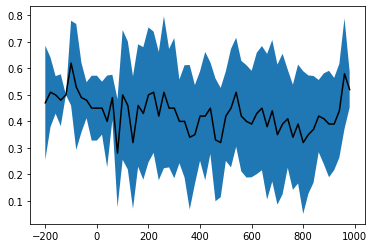

In [14]:
#plot results:

x_graph = np.arange(-200,1000,length_per_window)
y_graph = scoreMean
stdev = np.array(stdev)
error = stdev
plt.plot(x_graph, y_graph, 'k-')
plt.fill_between(x_graph, y_graph-error, y_graph+error)
plt.show()